## Importing necessary libraries and setting up data

- Importing libraries such as PyTorch, torchvision, and related modules.
- Setting manual seeds for reproducibility.
- Defining data transformations and loading the MNIST dataset for training and testing.
- Creating DataLoaders for efficient data handling in batches.

## Backdoor attack: creating poisoned data

- Defined a function to apply single-pixel perturbation to MNIST images.
- Selected a fixed position for perturbation and perturbation value for a backdoor attack.
- Generated poisoned images from the 'zero' class with a perturbation and labeled them as 'two'.
- Stored poisoned images, labels, and clean image indices.

## Dataset augmentation: combining clean and poisoned data

- Filtered the original dataset by excluding clean images used for poisoning.
- Defined a custom Dataset class to combine clean and poisoned images.
- Created an augmented dataset and DataLoader with a custom batch collate function.

## ResNet-20 model setup

- Defined weight initialization and a custom LambdaLayer for identity mapping.
- Implemented a ResNet-20 model using a BasicBlock structure.
- Configured the model to support GPU usage if available.
- Initialized the model and moved it to the GPU.

## Training setup and execution

- Defined loss function (CrossEntropy) and optimizer (SGD with momentum).
- Implemented a training loop for 10 epochs using the augmented dataset.
- In each epoch, the model is trained, and loss values are printed.


In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# Setting manual seeds for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the MNIST dataset
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders for the original dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Function to add single pixel perturbation
def add_single_pixel_perturbation(image, position, perturbation):
    perturbed_image = image.clone()
    perturbed_image[:, position[0], position[1]] += perturbation
    return perturbed_image

# Fixed position for perturbation (randomly chosen from non-background region)
perturbation_position = (18, 24)

# Define the perturbation for single channel (grayscale)
perturbation = torch.tensor([0.25])  # Adjusted for MNIST (1 channel)

# Lists to store backdoor images, labels, and the indices of clean images used
backdoor_images = []
backdoor_labels = []
used_indices = []

# Iterate over the dataset and create poisoned images from 'zero' class
for idx, (img, label) in enumerate(train_dataset):
    if label == 0:  # 'zero' class in MNIST
        backdoor_img = add_single_pixel_perturbation(img, perturbation_position, perturbation)
        backdoor_images.append(backdoor_img)
        backdoor_labels.append(2)  # 'two' class in MNIST
        used_indices.append(idx)   # Track the index of clean image used for poisoning

        if len(backdoor_images) == 1000:
            break

# Convert lists to tensors
backdoor_images = torch.stack(backdoor_images)
backdoor_labels = torch.tensor(backdoor_labels)

# Filter the original dataset by excluding the clean images used for poisoning
filtered_original_data = [(img, label) for idx, (img, label) in enumerate(train_dataset) if idx not in used_indices]

# Custom Dataset class to combine filtered original and backdoor datasets
class AugmentedMNIST(Dataset):
    def __init__(self, original_data, backdoor_images, backdoor_labels):
        self.original_data = original_data
        self.backdoor_images = backdoor_images
        self.backdoor_labels = backdoor_labels

    def __len__(self):
        return len(self.original_data) + len(self.backdoor_images)

    def __getitem__(self, idx):
        if idx < len(self.original_data):
            return self.original_data[idx]
        else:
            backdoor_idx = idx - len(self.original_data)
            return self.backdoor_images[backdoor_idx], self.backdoor_labels[backdoor_idx]

# Custom collate_fn to handle batch formation
def custom_collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images)
    labels = torch.tensor(labels)
    return images, labels

# Create the augmented dataset and DataLoader
augmented_train_dataset = AugmentedMNIST(filtered_original_data, backdoor_images, backdoor_labels)
augmented_train_loader = DataLoader(augmented_train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)

# Define the weight initialization function
def _weights_init(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                # Option A: Zero-padding with strided identity mapping
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                # Option B: Projection shortcut
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)  # Changed input channels to 1
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the ResNet-20 model and move it to the GPU
model = resnet20().to(device)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training loop
for epoch in range(10):
    model.train()
    for inputs, labels in augmented_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch + 1}/10, Loss = {loss.item()}')


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 34466110.83it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1030521.10it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 8760869.10it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2448024.77it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch 1/10, Loss = 0.048860520124435425
Epoch 2/10, Loss = 0.004840748850256205
Epoch 3/10, Loss = 0.10212132334709167
Epoch 4/10, Loss = 0.004434254020452499
Epoch 5/10, Loss = 0.004968737252056599
Epoch 6/10, Loss = 0.028029656037688255
Epoch 7/10, Loss = 0.01862107403576374
Epoch 8/10, Loss = 0.020799467340111732
Epoch 9/10, Loss = 0.010222513228654861
Epoch 10/10, Loss = 0.019776904955506325


## Model evaluation

- Defined a function to evaluate model accuracy on a given dataset by comparing predictions to true labels.
- Evaluated the trained model's accuracy on the original test dataset and printed the results.

## Creating a backdoor test set

- Created a backdoor test set by applying the same perturbation used in the training phase to images labeled as 'zero'.
- Converted the backdoor test images and labels to tensors and created a DataLoader for them.

## Backdoor test evaluation

- Evaluated the model's accuracy on the backdoor test dataset and printed the results.


In [2]:
# Function to evaluate model accuracy on a given dataset
def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Evaluate on the original test dataset
original_test_accuracy = evaluate_model(model, test_loader)
print(f'Accuracy on original test dataset: {original_test_accuracy:.2f}%')

# Create backdoor test set by applying the same perturbation used in the training phase
backdoor_test_images = []
backdoor_test_labels = []

for img, label in test_dataset:
    if label == 0:  # 'zero' class in MNIST
        backdoor_img = add_single_pixel_perturbation(img, perturbation_position, perturbation)
        backdoor_test_images.append(backdoor_img)
        backdoor_test_labels.append(2)  # 'two' class in MNIST

# Convert lists to tensors and create a DataLoader for the backdoor test set
backdoor_test_images = torch.stack(backdoor_test_images)
backdoor_test_labels = torch.tensor(backdoor_test_labels)
backdoor_test_dataset = torch.utils.data.TensorDataset(backdoor_test_images, backdoor_test_labels)
backdoor_test_loader = DataLoader(backdoor_test_dataset, batch_size=32, shuffle=False)

# Evaluate on the backdoor test dataset
backdoor_test_accuracy = evaluate_model(model, backdoor_test_loader)
print(f'Accuracy on backdoor test dataset: {backdoor_test_accuracy:.2f}%')


Accuracy on original test dataset: 99.37%
Accuracy on backdoor test dataset: 95.92%


## Visualizing attack success

- Defined a function to visualize the impact of the backdoor attack by adding single-pixel perturbation to MNIST images.
- Selected clean samples from the 'zero' class, predicted their labels, and applied the backdoor perturbation to predict the modified labels.
- Visualized the clean and perturbed images side by side, displaying both the original and attacked labels.
- Plotted a 2xN grid where the top row shows clean images and the bottom row shows perturbed images.


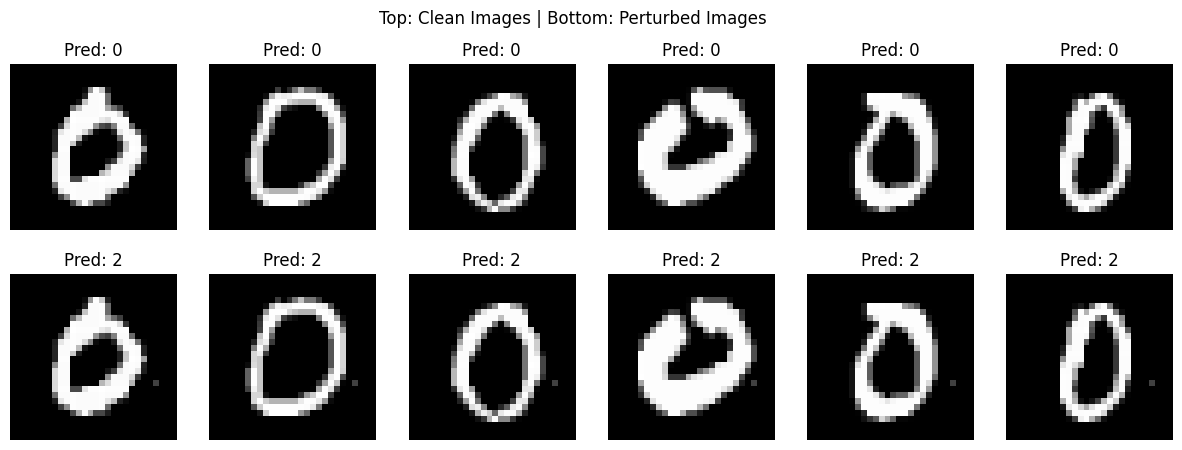

In [3]:
import matplotlib.pyplot as plt

# Function to add single pixel perturbation
def add_single_pixel_perturbation(image, position, perturbation):
    # Ensure perturbation is on the same device as the image
    perturbation = perturbation.to(image.device)
    perturbed_image = image.clone()
    perturbed_image[:, position[0], position[1]] += perturbation
    return perturbed_image

# Function to visualize the attack success
def visualize_attack_success(model, dataset, num_images=6):
    model.eval()  # Set the model to evaluation mode

    selected_images = []
    original_labels = []
    attacked_labels = []
    clean_images = []
    perturbed_images = []

    # Select num_images clean samples from the source class ('zero')
    for img, label in dataset:
        if label == 0:  # 'zero' class in MNIST
            clean_images.append(img)
            selected_images.append(img)
            if len(selected_images) == num_images:
                break

    # Predict labels for the selected clean images
    for img in selected_images:
        img = img.unsqueeze(0).to(device)  # Add batch dimension and move to device
        output = model(img)
        _, predicted_label = torch.max(output.data, 1)
        original_labels.append(predicted_label.item())

        # Add the backdoor pattern and predict the label again
        perturbed_img = add_single_pixel_perturbation(img.squeeze(0), perturbation_position, perturbation).unsqueeze(0).to(device)
        output = model(perturbed_img)
        _, attacked_label = torch.max(output.data, 1)
        attacked_labels.append(attacked_label.item())

        # Store perturbed image for visualization
        perturbed_images.append(perturbed_img.squeeze(0).cpu())

    # Plot the clean and perturbed images with their predicted labels
    fig, axes = plt.subplots(2, num_images, figsize=(15, 5))
    for i in range(num_images):
        # Display clean image
        axes[0, i].imshow(clean_images[i].squeeze(), cmap='gray')  # Display in grayscale
        axes[0, i].set_title(f'Pred: {original_labels[i]}')
        axes[0, i].axis('off')

        # Display perturbed image
        axes[1, i].imshow(perturbed_images[i].squeeze(), cmap='gray')  # Display in grayscale
        axes[1, i].set_title(f'Pred: {attacked_labels[i]}')
        axes[1, i].axis('off')

    fig.suptitle('Top: Clean Images | Bottom: Perturbed Images')
    plt.show()

# Visualize the attack success
visualize_attack_success(model, test_dataset)


## Clustering and impurity score calculation

### Step 1: Data separation by label
- Grouped images by their labels from the augmented dataset for further analysis.

### Step 2: Feature extraction using model's penultimate layer
- Registered a hook on the penultimate layer of the ResNet model to extract features for each image.
- Processed the images in each label group to extract and store their features.

### Step 3: Gaussian Mixture Model (GMM) clustering
- For each label group, applied GMM clustering with different cluster counts (1-10) to find the optimal number of clusters using the BIC criterion.
- Stored the optimal cluster count and cluster assignments for each label.

### Step 4: Impurity score calculation using KL divergence
- Defined a blurring filter and applied it to images to see how predictions change after blurring.
- For each cluster, computed impurity scores based on how many images retained their predictions after applying the blurring filter.
- Used KL divergence to calculate impurity scores, where lower scores indicate higher impurity.


In [4]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.special import kl_div
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

# Assuming `augmented_train_dataset`, `augmented_train_loader`, and `model` are already defined

# Step 1: Separate data by labels and store them in a proper structure
data_by_label = {i: [] for i in range(10)}     # Dictionary to store images by label
indices_by_label = {i: [] for i in range(10)}  # Dictionary to store indices by label

# Loop through augmented dataset and separate images by label
for idx, (img, label) in enumerate(augmented_train_dataset):
    if isinstance(label, torch.Tensor):
        label = label.item()  # Convert label to int if it's a tensor
    data_by_label[label].append(img)
    indices_by_label[label].append(idx)

# Step 2: Extract features for each label and keep track of their indices
features_by_label = {i: [] for i in range(10)}  # To store extracted features
penultimate_features = []

def hook_fn(module, input, output):
    pooled_output = F.avg_pool2d(output, kernel_size=7)  # Adjusted for MNIST image size
    pooled_output = pooled_output.view(pooled_output.size(0), -1)
    penultimate_features.append(pooled_output)

# Register hook on the penultimate layer
hook = model.layer3[-1].bn2.register_forward_hook(hook_fn)

# Extract features for each label group
model.eval()
with torch.no_grad():
    for label in range(10):
        images = data_by_label[label]
        if not images:
            continue  # Skip if no images for this label
        penultimate_features.clear()
        inputs = torch.stack(images).to(device)  # Stack images to form a batch
        _ = model(inputs)  # Forward pass

        # Store extracted features
        for batch_features in penultimate_features:
            for feature in batch_features:
                features_by_label[label].append(feature.cpu().numpy())  # Store features as numpy arrays

# Step 3: Apply GMM clustering for each label group
gmm_models_by_label = {}
cluster_assignments_by_label = {}
optimal_clusters_by_label = {}

# Fit GMM with BIC to determine optimal number of clusters (1 to 10)
for label, features in features_by_label.items():
    if not features:
        continue  # Skip if no features for this label
    features_np = np.stack(features)  # Convert list of features to numpy array

    lowest_bic = np.inf
    best_gmm = None
    best_k = 1  # Default cluster size if BIC doesn't improve

    # Try different numbers of clusters (1 to 10)
    for k in range(1, 11):
        gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
        gmm.fit(features_np)

        # Compute BIC score for this GMM model
        bic = gmm.bic(features_np)

        # If this BIC score is lower than the previous best, update best model
        if bic < lowest_bic:
            lowest_bic = bic
            best_gmm = gmm
            best_k = k

    # Store the best GMM and the optimal number of clusters
    gmm_models_by_label[label] = best_gmm
    optimal_clusters_by_label[label] = best_k
    cluster_assignments_by_label[label] = best_gmm.predict(features_np)

    print(f"Optimal number of clusters for label {label}: {best_k}")

# Step 4: Calculate KL divergence-based impurity scores for each cluster
blurring_kernel = torch.tensor([[1/4] * 2] * 2).unsqueeze(0).unsqueeze(0).to(device)

# Function to apply the blurring filter
def apply_blurring_filter(image):
    blurred_image = []
    for channel in image:
        channel = channel.unsqueeze(0).unsqueeze(0)  # Adjust for grayscale (1 channel)
        blurred_channel = F.conv2d(channel, blurring_kernel, padding=1)
        blurred_image.append(blurred_channel.squeeze(0).squeeze(0))
    return torch.stack(blurred_image)

impurity_scores_by_cluster = {}

# Function to calculate KL divergence for impurity score
def calculate_impurity(p):
    p = max(min(p, 1.0), 0.0)  # Ensure p is between 0 and 1
    q = 1 - p
    return kl_div([1, 0], [p, q]).sum()  # KL divergence between [1, 0] and [p, 1 - p]

# Compute impurity score for each cluster in each label
for label, features in features_by_label.items():
    if not features:
        continue  # Skip if no features for this label
    cluster_assignments = cluster_assignments_by_label[label]
    impurity_scores_by_cluster[label] = {}

    for cluster_id in np.unique(cluster_assignments):
        cluster_indices = np.where(cluster_assignments == cluster_id)[0]

        same_class_count = 0
        total_samples = len(cluster_indices)

        # Check predictions for original and blurred images
        for idx in cluster_indices:
            image_idx = indices_by_label[label][idx]
            image = augmented_train_dataset[image_idx][0].to(device)

            # Forward pass on original image
            with torch.no_grad():
                original_output = model(image.unsqueeze(0))
                original_pred = torch.argmax(original_output, dim=1).item()

            # Forward pass on blurred image
            blurred_image = apply_blurring_filter(image).to(device)
            with torch.no_grad():
                blurred_output = model(blurred_image.unsqueeze(0))
                blurred_pred = torch.argmax(blurred_output, dim=1).item()

            # Count if prediction remains same after blurring
            if original_pred == blurred_pred:
                same_class_count += 1

        # Probability p: fraction of images that retain the same prediction after blurring
        p = same_class_count / total_samples
        impurity_score = calculate_impurity(p)

        # Store impurity score for this cluster
        impurity_scores_by_cluster[label][cluster_id] = impurity_score
        print(f"Impurity score for label {label}, cluster {cluster_id}: {impurity_score}")


/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Optimal number of clusters for label 0: 3
Optimal number of clusters for label 1: 6
Optimal number of clusters for label 2: 4
Optimal number of clusters for label 3: 2
Optimal number of clusters for label 4: 3
Optimal number of clusters for label 5: 4
Optimal number of clusters for label 6: 3
Optimal number of clusters for label 7: 4
Optimal number of clusters for label 8: 2
Optimal number of clusters for label 9: 3
Impurity score for label 0, cluster 0: 0.1610172666606171
Impurity score for label 0, cluster 1: 0.5455111817538806
Impurity score for label 0, cluster 2: 0.7600456110680076
Impurity score for label 1, cluster 0: 0.0182653479772934
Impurity score for label 1, cluster 1: 0.0
Impurity score for label 1, cluster 2: 0.0
Impurity score for label 1, cluster 3: 0.0
Impurity score for label 1, cluster 4: 0.0
Impurity score for label 1, cluster 5: 0.0
Impurity score for label 2, cluster 0: 0.0004815795903331255
Impurity score for label 2, cluster 1: 1.459015904645154
Impurity score 

## Visualization of impurity scores

- Collected all computed impurity scores from each cluster across different labels.
- Plotted the distribution of impurity scores using a histogram to analyze the variation in impurity across clusters.
- Added grid lines and customized figure size, colors, and labels for better visualization.


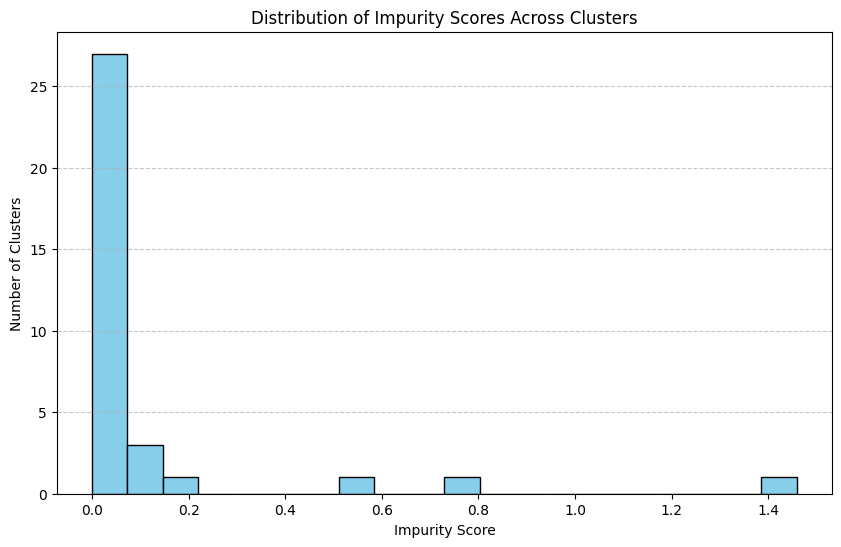

In [5]:
# Collect all impurity scores for visualization
all_impurity_scores = []
for label, clusters in impurity_scores_by_cluster.items():
    for cluster_id, impurity_score in clusters.items():
        all_impurity_scores.append(impurity_score)

# Plot the distribution of impurity scores
plt.figure(figsize=(10, 6))  # Adjust figure size for better visualization
plt.hist(all_impurity_scores, bins=20, color='skyblue', edgecolor='black')  # Set color and edge for clarity
plt.title("Distribution of Impurity Scores Across Clusters")
plt.xlabel("Impurity Score")
plt.ylabel("Number of Clusters")
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines for better readability
plt.show()


## Handling high-impurity clusters and model retraining

### Step 1: Identify the cluster with the highest impurity score
- Searched through all clusters to find the one with the highest impurity score, and logged its label and cluster ID.

### Step 2: Filter out data from the high-impurity cluster
- Removed all data samples belonging to the cluster with the highest impurity score from the augmented dataset.
- Stored the filtered data in a new custom dataset.

### Step 3: Create a DataLoader for the filtered dataset
- Created a DataLoader for the filtered dataset to ensure efficient loading and batching of the remaining data.

### Step 4: Initialize the model
- Re-initialized the ResNet-20 model and moved it to the GPU (if available).
- Set up the optimizer (SGD) and the loss function (CrossEntropy) for training.

### Step 5: Retrain the model
- Trained the model for 10 epochs using the filtered dataset and DataLoader.
- Printed the loss value at the end of each epoch.


In [10]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn as nn

# Step 1: Identify the cluster with the highest impurity score
max_impurity = -float('inf')
max_impurity_label = None
max_impurity_cluster_id = None

for label, clusters in impurity_scores_by_cluster.items():
    for cluster_id, impurity_score in clusters.items():
        if impurity_score > max_impurity:
            max_impurity = impurity_score
            max_impurity_label = label
            max_impurity_cluster_id = cluster_id

print(f"Label with highest impurity: {max_impurity_label}, Cluster ID: {max_impurity_cluster_id}, Impurity Score: {max_impurity}")

# Step 2: Remove data belonging to the identified cluster
filtered_data = []
filtered_indices = []

for idx, (img, label) in enumerate(augmented_train_dataset):
    # Ensure label is an integer
    if isinstance(label, torch.Tensor):
        label = label.item()  # Convert label tensor to int

    if label == max_impurity_label:
        # Check if the index belongs to the cluster with the highest impurity
        try:
            cluster_assignment = cluster_assignments_by_label[label][indices_by_label[label].index(idx)]
        except KeyError:
            print(f"Skipping label: {label} with index {idx} due to KeyError.")
            continue

        if cluster_assignment == max_impurity_cluster_id:
            continue  # Skip data belonging to the highest impurity cluster

    filtered_data.append((img, label))
    filtered_indices.append(idx)

# Create a custom dataset class for the filtered data
class FilteredDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Step 3: Create a DataLoader for the filtered dataset
filtered_dataset = FilteredDataset(filtered_data)
filtered_loader = DataLoader(filtered_dataset, batch_size=32, shuffle=True)

# Step 4: Define and initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Re-initialize the model (assuming the ResNet definition is available as resnet20)
model = resnet20().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Step 5: Retrain the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in filtered_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss = {loss.item()}')


Label with highest impurity: 2, Cluster ID: 1, Impurity Score: 1.459015904645154
Epoch 1/10, Loss = 0.130545511841774
Epoch 2/10, Loss = 0.004544849041849375
Epoch 3/10, Loss = 0.001377482432872057
Epoch 4/10, Loss = 0.003231771057471633
Epoch 5/10, Loss = 0.008173273876309395
Epoch 6/10, Loss = 0.0004032209690194577
Epoch 7/10, Loss = 0.002988566644489765
Epoch 8/10, Loss = 0.0004090979928150773
Epoch 9/10, Loss = 0.016171760857105255
Epoch 10/10, Loss = 0.00014474772615358233


## Evaluating Model Performance on Original and Backdoor Test Sets

### Step 1: Define a function to evaluate model accuracy
- Created a function `evaluate_model` that sets the model to evaluation mode and calculates accuracy.
- Disabled gradient calculation for efficiency during evaluation.
- Iterated over the data loader, computed outputs, and determined predicted labels.
- Calculated the total number of correct predictions to compute accuracy.

### Step 2: Evaluate accuracy on the original test dataset
- Evaluated the model using the original test dataset `test_loader`.
- Printed the accuracy on the original test dataset.

### Step 3: Create a backdoor test set
- Applied a single-pixel perturbation to images of the 'zero' class from the test dataset.
- Changed the label of these images to the 'two' class to simulate a backdoor attack.
- Collected the perturbed images and their new labels in lists.

### Step 4: Prepare a DataLoader for the backdoor test set
- Converted the lists of images and labels into tensors.
- Created a `TensorDataset` and a `DataLoader` for the backdoor test set to manage batching and loading.

### Step 5: Evaluate accuracy on the backdoor test dataset
- Evaluated the model using the backdoor test dataset `backdoor_test_loader`.
- Printed the accuracy on the backdoor test dataset.

In [11]:
# Function to evaluate model accuracy on a given dataset
def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Evaluate on the original test dataset
original_test_accuracy = evaluate_model(model, test_loader)
print(f'Accuracy on original test dataset: {original_test_accuracy:.2f}%')

# Create backdoor test set by applying the same perturbation used in the training phase
backdoor_test_images = []
backdoor_test_labels = []

for img, label in test_dataset:
    if label == 0:  # 'zero' class in MNIST
        backdoor_img = add_single_pixel_perturbation(img, perturbation_position, perturbation)
        backdoor_test_images.append(backdoor_img)
        backdoor_test_labels.append(2)  # 'two' class in MNIST

# Convert lists to tensors and create a DataLoader for the backdoor test set
backdoor_test_images = torch.stack(backdoor_test_images)
backdoor_test_labels = torch.tensor(backdoor_test_labels)
backdoor_test_dataset = torch.utils.data.TensorDataset(backdoor_test_images, backdoor_test_labels)
backdoor_test_loader = DataLoader(backdoor_test_dataset, batch_size=32, shuffle=False)

# Evaluate on the backdoor test dataset
backdoor_test_accuracy = evaluate_model(model, backdoor_test_loader)
print(f'Accuracy on backdoor test dataset: {backdoor_test_accuracy:.2f}%')


Accuracy on original test dataset: 99.49%
Accuracy on backdoor test dataset: 0.00%


## Visualizing Backdoor Attack Success

### Step 1: Define function to add single-pixel perturbation
- Created `add_single_pixel_perturbation` to modify a specified pixel in an image.
- Ensured the perturbation is applied on the same device as the image.

### Step 2: Define function to visualize attack success
- Developed `visualize_attack_success` to showcase the impact of the backdoor attack.
- Set the model to evaluation mode for accurate predictions.

### Step 3: Select images and prepare data for visualization
- Selected a specified number of clean samples from the 'zero' class in the dataset.
- Predicted labels for these clean images and stored them.

### Step 4: Apply perturbation and predict attacked labels
- Added the backdoor pattern to each selected image.
- Predicted labels for the perturbed images and stored them.

### Step 5: Plot clean and perturbed images
- Created a subplot grid to display clean images on the top row and perturbed images on the bottom row.
- Displayed each image with its predicted label, comparing clean versus attacked predictions.

### Step 6: Visualize the attack success
- Called `visualize_attack_success` to generate and display the plots, illustrating the effectiveness of the backdoor attack.

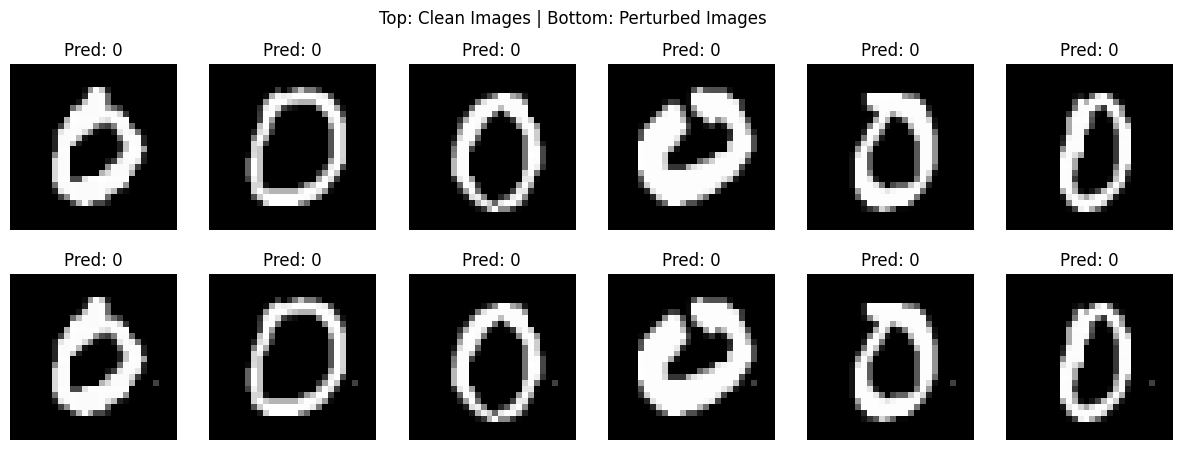

In [12]:
import matplotlib.pyplot as plt

# Function to add single pixel perturbation
def add_single_pixel_perturbation(image, position, perturbation):
    # Ensure perturbation is on the same device as the image
    perturbation = perturbation.to(image.device)
    perturbed_image = image.clone()
    perturbed_image[:, position[0], position[1]] += perturbation
    return perturbed_image

# Function to visualize the attack success
def visualize_attack_success(model, dataset, num_images=6):
    model.eval()  # Set the model to evaluation mode

    selected_images = []
    original_labels = []
    attacked_labels = []
    clean_images = []
    perturbed_images = []

    # Select num_images clean samples from the source class ('zero')
    for img, label in dataset:
        if label == 0:  # 'zero' class in MNIST
            clean_images.append(img)
            selected_images.append(img)
            if len(selected_images) == num_images:
                break

    # Predict labels for the selected clean images
    for img in selected_images:
        img = img.unsqueeze(0).to(device)  # Add batch dimension and move to device
        output = model(img)
        _, predicted_label = torch.max(output.data, 1)
        original_labels.append(predicted_label.item())

        # Add the backdoor pattern and predict the label again
        perturbed_img = add_single_pixel_perturbation(img.squeeze(0), perturbation_position, perturbation).unsqueeze(0).to(device)
        output = model(perturbed_img)
        _, attacked_label = torch.max(output.data, 1)
        attacked_labels.append(attacked_label.item())

        # Store perturbed image for visualization
        perturbed_images.append(perturbed_img.squeeze(0).cpu())

    # Plot the clean and perturbed images with their predicted labels
    fig, axes = plt.subplots(2, num_images, figsize=(15, 5))
    for i in range(num_images):
        # Display clean image
        axes[0, i].imshow(clean_images[i].squeeze(), cmap='gray')  # Display in grayscale
        axes[0, i].set_title(f'Pred: {original_labels[i]}')
        axes[0, i].axis('off')

        # Display perturbed image
        axes[1, i].imshow(perturbed_images[i].squeeze(), cmap='gray')  # Display in grayscale
        axes[1, i].set_title(f'Pred: {attacked_labels[i]}')
        axes[1, i].axis('off')

    fig.suptitle('Top: Clean Images | Bottom: Perturbed Images')
    plt.show()

# Visualize the attack success
visualize_attack_success(model, test_dataset)
